# Machine Learning Lab: CA - 2
Submitted by Bharath Vignesh J K (19PW08)

## Objective: 
**From the mammogram report text, we try to predict if the given individual needs a biopsy or not.**

After analyzing the domain it can be concluded that if the patient has a Birad Score above 4 he requires a biopsy, those with a birad score below or equal to 4 don't require a biopsy immediately. So we assume those as the classification target. The provided dataset is altered accordingly for binary classification.

**Note:** This notebook doesn't aim for better accuracy, its just documents the predictions with various machine learning models along with their prediction measures.

## Feature details:

**Input Features:** Vector Representation of cleaned/processeed mammogram report is used as the Input parameters.

**Output Features:** Boolean value that is the prediction of the model indicated if the person requires biopsy.

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [26]:
# Reading the data set
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mammoreport.csv")
df.head()

# Preprocessing
Cleaning and converting the dataset for processing with ML Models

### Generating target feature based on birad score for Binary classification

In [3]:
birads = df["Birads"].copy()
for i in range(0, len(birads)):
  if birads.iloc[i] > 4:
    birads.iloc[i] = 1
  else:
    birads.iloc[i] = 0
Y = birads.to_numpy()

### Converting to string of lowercase and striping spaces

In [4]:
df["Features"] = df["Features"].astype(str)
df["Features"] = df["Features"].str.lower()
df["Features"] = df["Features"].str.strip()
df.head()

,Features,Birads
0,soft tissue mass lesion (23 x 20 mm) with spic...,4
1,parenchyma is predominantly fatty.no distinctl...,1
2,parenchyma is predominantly glandular. no dist...,1
3,parenchyma is predominantly glandular. no dist...,2
4,parenchyma is glandular and fatty. small subce...,2


### Removing punctuations

In [5]:
import re
df["Features"] = df["Features"].apply(lambda text: re.sub(r'[^\w\s]',' ', text))
df.head()

,Features,Birads
0,soft tissue mass lesion 23 x 20 mm with spic...,4
1,parenchyma is predominantly fatty no distinctl...,1
2,parenchyma is predominantly glandular no dist...,1
3,parenchyma is predominantly glandular no dist...,2
4,parenchyma is glandular and fatty small subce...,2


### Removing stopwords from the data

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords

df["Features"] = df["Features"].apply(lambda text: " ".join([word for word in text.split() if word not in stopwords.words('english')]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Features,Birads
0,soft tissue mass lesion 23 x 20 mm spiculated ...,4
1,parenchyma predominantly fatty distinctly iden...,1
2,parenchyma predominantly glandular distinctly ...,1
3,parenchyma predominantly glandular distinctly ...,2
4,parenchyma glandular fatty small subcentimeter...,2


### Lemmetizing the report data

In [7]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

def lemmetizeText(text):
    sentences = []
    for sentence in nltk.sent_tokenize(text):
        sentences.append(" ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) ]))
    return "".join(sentences)

df.loc[:,"Features"] = df.Features.apply(lemmetizeText)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Features,Birads
0,soft tissue mass lesion 23 x 20 mm spiculated ...,4
1,parenchyma predominantly fatty distinctly iden...,1
2,parenchyma predominantly glandular distinctly ...,1
3,parenchyma predominantly glandular distinctly ...,2
4,parenchyma glandular fatty small subcentimeter...,2


In [8]:
# # Stemming the input
# from nltk.stem.porter import PorterStemmer

# stemmer = PorterStemmer()
# def stem_words(text):
#     return " ".join([stemmer.stem(word) for word in text.split()])

# df["Features"] = df["Features"].apply(lambda text: stem_words(text))
# df.head()

### Generating Vector Representation

Term Frequency was initialially tested with various SVM(SVC) with various kernal functions. But it yielded very low prediction measures. Using tfidf yielded better results.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = TfidfVectorizer()
# frequencies = vectorizer.fit_transform(df['Features']).toarray()
# X = frequencies

vectorizer = CountVectorizer()
word_frequencies = vectorizer.fit_transform(df['Features']).toarray()
X = word_frequencies

term_frequencies = []
for row in word_frequencies:
    total_words = np.count_nonzero(row)
    term_frequencies.append(np.array([count/float(total_words) for count in row]))

X = np.array(term_frequencies)


### Word Clouds

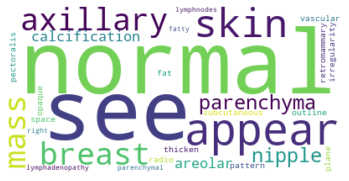

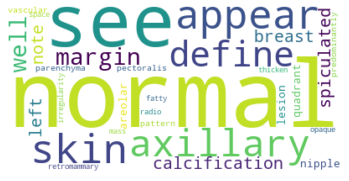

In [10]:
from collections import Counter
from wordcloud import WordCloud

counters = [Counter() for _ in np.unique(Y)]
for i in range(len(X)):
  text = df["Features"].iloc[i]
  for word in text.split():
    counters[Y[i]][word] += 1

for i in range(len(counters)):
  text = " ".join([x[0] for x in counters[i].most_common(30)])
  wordcloud = WordCloud(background_color ='white').generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")  
  plt.show()


## Heatmap

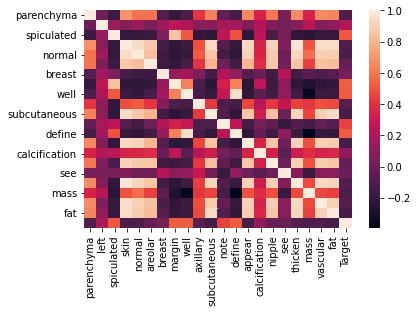

In [11]:
import seaborn as sb

index_names = set()
for y in np.unique(Y):
  [index_names.add((i, name)) for i, name in enumerate(vectorizer.get_feature_names()) if name in [x[0] for x in counters[y].most_common(10)]]

heatmap_data = {}
for index, name in index_names:
  heatmap_data[name] = X[:, index]
heatmap_data["Target"] = Y

sb.heatmap(pd.DataFrame(heatmap_data).corr())

# Testing Models

### Utility functions for Report generation

In [12]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut


def get_binary_classification_measures(y_actual, y_pred):
    print('Accuracy  : ', accuracy_score(y_actual, y_pred))
    print('Precision : ', precision_score(y_actual, y_pred))
    print('Recall    : ', recall_score(y_actual, y_pred))
    print('F1 Score  : ', f1_score(y_actual, y_pred))
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.show()
    print('ROC AUC   : ', roc_auc_score(y_actual, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_actual, y_pred))
    print("***********************************************************")

def get_leave_one_out_report(classifier, binary=True, **kwargs):
    loo = LeaveOneOut()
    overall_y_test = []
    overall_y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        cf = classifier(**kwargs)
        cf.fit(X_train, y_train)
        y_pred = cf.predict(X_test)
        overall_y_test.extend(y_test)
        overall_y_pred.extend(y_pred)

    if binary:
        get_binary_classification_measures(overall_y_test, overall_y_pred)
    else:        
        print(classification_report(overall_y_test, overall_y_pred, zero_division=0))

### SVM with Linear Kernal Function

Accuracy  :  0.9626168224299065
Precision :  1.0
Recall    :  0.5555555555555556
F1 Score  :  0.7142857142857143


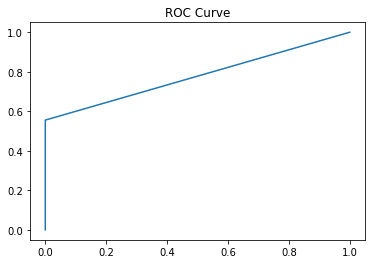

ROC AUC   :  0.7777777777777778
Confusion Matrix: 
 [[98  0]
 [ 4  5]]
***********************************************************


In [13]:
from sklearn.svm import SVC
get_leave_one_out_report(SVC, kernel="linear")

### SVM with Polynomial Kernal Function

Accuracy  :  0.9439252336448598
Precision :  0.7142857142857143
Recall    :  0.5555555555555556
F1 Score  :  0.6250000000000001


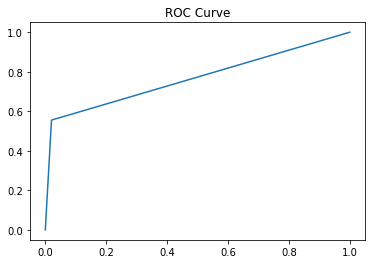

ROC AUC   :  0.7675736961451247
Confusion Matrix: 
 [[96  2]
 [ 4  5]]
***********************************************************


In [14]:
get_leave_one_out_report(SVC, kernel="poly")

### SVM with Sigmoidal Kernal Function

Accuracy  :  0.9252336448598131
Precision :  1.0
Recall    :  0.1111111111111111
F1 Score  :  0.19999999999999998


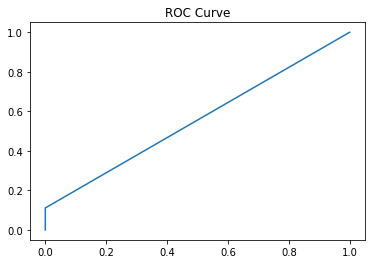

ROC AUC   :  0.5555555555555556
Confusion Matrix: 
 [[98  0]
 [ 8  1]]
***********************************************************


In [15]:
get_leave_one_out_report(SVC, kernel="sigmoid")

### Logistic Regression

Accuracy  :  0.8130841121495327
Precision :  0.28
Recall    :  0.7777777777777778
F1 Score  :  0.4117647058823529


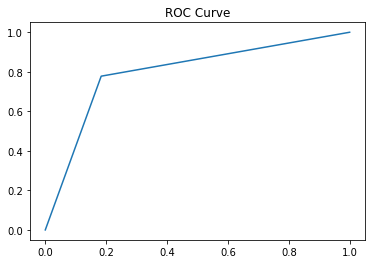

ROC AUC   :  0.7970521541950113
Confusion Matrix: 
 [[80 18]
 [ 2  7]]
***********************************************************


In [16]:
import math
import numpy as np

class LogisticRegression:    
    def __init__(self, eta=0.01, max_iter=500):
        self.weights = None
        self.eta = eta
        self.max_iter = max_iter

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + math.exp(-x))
    
    def predict(self, x_data):
        if self.weights is None:
            raise ValueError("Model was never trained")
        return np.array([1 if self.sigmoid(np.dot(self.weights, x)) >= 0.5 else 0 for x in x_data])

    def fit(self, x_data, y_data):
        x_data = np.copy(x_data)
        np.c_[x_data, np.ones(len(x_data))] 
        self.weights = np.random.rand(x_data.shape[1])
        converged = False
        iters = 0
        while not converged and iters < self.max_iter:
            converged = True
            for i in range(len(x_data)):
                sig = self.sigmoid(np.dot(self.weights, x_data[i]))
                y_hat = 1 if sig >= 0.5 else 0
                if y_hat != y_data[i]:
                    self.weights = self.weights + (y_data[i] - sig) * self.eta * x_data[i]    
                    converged = False
            iters += 1
        return self.weights

get_leave_one_out_report(LogisticRegression)

### Perceptron

Accuracy  :  0.822429906542056
Precision :  0.2727272727272727
Recall    :  0.6666666666666666
F1 Score  :  0.3870967741935484


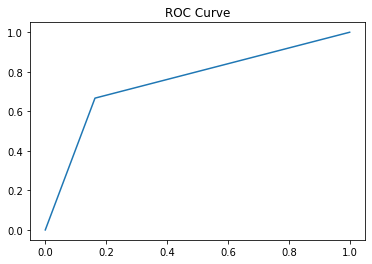

ROC AUC   :  0.7517006802721088
Confusion Matrix: 
 [[82 16]
 [ 3  6]]
***********************************************************


In [17]:
import numpy as np

class Perceptron:
    def __init__(self, eta=0.01, max_iter=500):
        self.weights = None
        self.eta = eta
        self.max_iter = max_iter
    
    def predict(self, x_data):
        if self.weights is None:
            raise ValueError("Model was never trained")
        return np.array([1 if np.dot(self.weights, x) > 0 else 0 for x in x_data])

    def fit(self, x_data, y_data):
        x_data = np.copy(x_data)
        np.c_[x_data, np.ones(len(x_data))] 
        self.weights = np.random.rand(x_data.shape[1])
        converged = False
        iters = 0
        while not converged and iters < self.max_iter:
            converged = True
            for i in range(len(x_data)):
                y_hat = 1 if np.dot(self.weights, x_data[i]) > 0 else 0
                if y_data[i] != y_hat:
                  converged = False
                  if y_data[i] == 0:
                    self.weights -= self.eta * x_data[i]
                  else:
                    self.weights += self.eta * x_data[i]
            iters += 1
        return self.weights

get_leave_one_out_report(Perceptron)

### K Nearest Neighbours(Cosine Distance)

In [18]:
class KNN:
  def __init__(self, k = 3, dist = lambda x, y: np.linalg.norm(x - y)):
    self.x_train = None
    self.y_train = None
    self.k = k
    self.dist = dist

  def __get_top_k_neighbours(self, x):
    dists = [(self.y_train[i], self.dist(x, self.x_train[i])) for i in range(len(self.x_train))]
    dists.sort(key=lambda x: x[1])
    return dists[:self.k + 1]  

  def __get_class_from_neighbours(self, neighbours_data):
    counts = [0, 0]
    for neighbour_data in neighbours_data:
        counts[neighbour_data[0]] += 1
    return 1 if counts[1] > counts[0] else 0

  def __get_prediction(self, x):
    neighbours_data = self.__get_top_k_neighbours(x)
    return self.__get_class_from_neighbours(neighbours_data)

  def predict(self, x_data):
    return np.array([self.__get_prediction(x) for x in x_data])

  def fit(self, x_data, y_data):
    self.x_train = x_data
    self.y_train = y_data

**Observation:** L2 Norm gave better results than cosine distance

Cosine Distance
K=1
Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


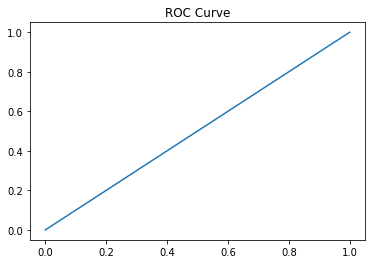

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************
K=3
Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


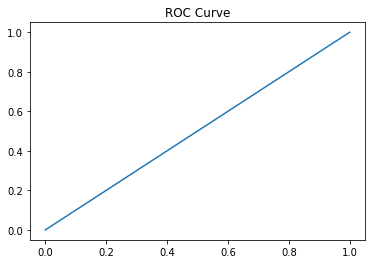

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************
K=5
Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


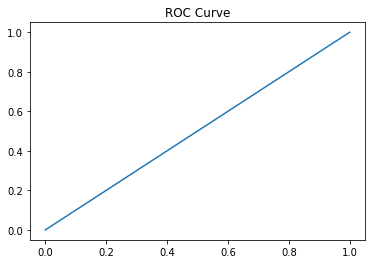

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************
K=7
Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


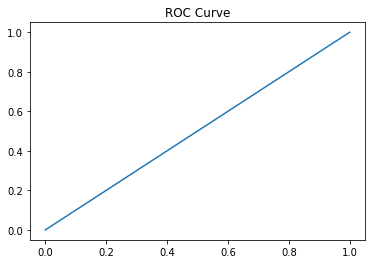

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************
K=9
Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


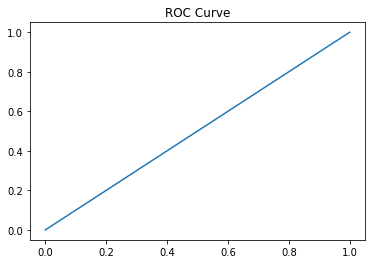

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************
K=11
Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


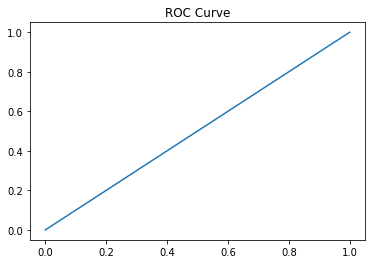

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************
K=13
Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


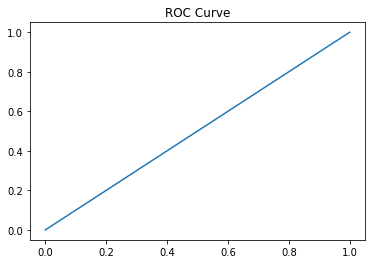

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************
L2 Norm
Accuracy  :  0.9439252336448598
Precision :  0.7142857142857143
Recall    :  0.5555555555555556
F1 Score  :  0.6250000000000001


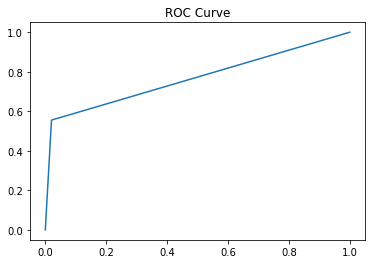

ROC AUC   :  0.7675736961451247
Confusion Matrix: 
 [[96  2]
 [ 4  5]]
***********************************************************


In [19]:
cosine_dist = lambda a, b: np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))
print(f"Cosine Distance")
for i in range(1, 15, 2):
  print(f"K={i}")
  get_leave_one_out_report(KNN, k=i, dist=cosine_dist)
print(f"L2 Norm")
get_leave_one_out_report(KNN)

### Gaussian Naive Bayes Classification




Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


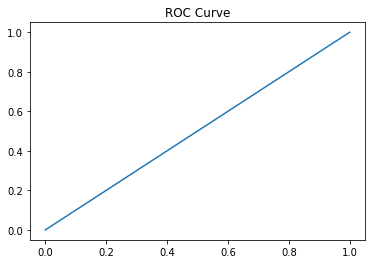

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************


In [27]:
import numpy as np

class GaussianNB:
  def __init__(self):
    self.prior = None

  def __get_prediction(self, x):
    probs = list()
    for i in range(len(self.prior)):
        power = -0.5*(x- self.mean_list[i])  @ np.linalg.inv(self.cov_list[i]) @ np.transpose(x-self.mean_list[i])
        exponent = math.exp(power)
        prob = math.sqrt(np.linalg.det(self.cov_list[i])/(2 * math.pi)**(len(x.shape)))*exponent
        probs.append(prob* self.prior[i])
    return [prob/sum(probs) for prob in probs] if sum(probs) != 0 else 0

  def predict(self, x_data):
    return np.array([self.__get_prediction(x) for x in x_data])

  def fit(self, x_data, y_data):
    self.prior = {}
    for class_label in y_data:
        if class_label not in self.prior:
            self.prior[class_label] = 0
        else:
            self.prior[class_label] += 1
    for key, value in self.prior.items():
        self.prior[key] = self.prior[key] / y_data.shape[0]

    self.cov_list = list()
    self.mean_list = list()

    data = {}
    for name in vectorizer.get_feature_names():
        data[name] = X[:, index]
    data["Target"] = Y
    temp_df = pd.DataFrame(data)

    for class_label in np.unique(y_data):
      temp = temp_df.loc[temp_df["Target"] == class_label]
      matrix = temp[temp.columns.difference(["Target"])]
      cov_matrix = np.zeros((matrix.shape[1], matrix.shape[1]))
      variance = list()
      for column in matrix:
          variance.append(matrix[column].var())
      np.fill_diagonal(cov_matrix, variance)
      self.cov_list.append(cov_matrix)
      self.mean_list.append(matrix.mean().to_numpy())

get_leave_one_out_report(GaussianNB)

### Bernoulli Naive Bayes Classification
CPT construction takes too long. Around 10 minutes for the whole dataset with LeaveOneOut

Accuracy  :  0.9158878504672897
Precision :  0.0
Recall    :  0.0
F1 Score  :  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


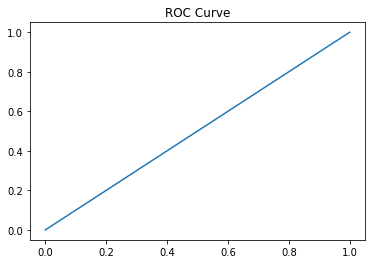

ROC AUC   :  0.5
Confusion Matrix: 
 [[98  0]
 [ 9  0]]
***********************************************************


In [28]:
import numpy as np

class BernoulliNB:
  def __init__(self):
    self.prior = None

  def __get_prediction(self, x):
    for i in [0, 1]:
      nums = [1, 1]
      for val, cpt_table in zip(x, self.cpts):
        val = "Yes" if val == 1 else "No"
        for i in [0, 1]:
          nums[i] *= cpt_table[val][i]
      nums /= sum(nums)
      return 1 if nums[1] > nums[0] else 0

  def predict(self, x_data):
    return np.array([self.__get_prediction(x) for x in x_data])

  def fit(self, x_data, y_data):
    total_count = x_data.shape[0]
    x_data[x_data > 0] = 1
    class_seperated_data = [[x for x, y in zip(x_data, y_data) if y == c] for c in np.unique(y_data)]
    self.counts = {"Yes": len(class_seperated_data[1]), "No": len(class_seperated_data[0])}
    self.prior = np.array([len(x)/total_count for x in class_seperated_data])
    self.cpts = [pd.DataFrame({"Yes": [0, 0], "No":[0, 0]}, index=[0, 1]) for _ in range(x_data.shape[1])]
    for x_point, y_point in zip(x_data, y_data):
      for j, x in enumerate(x_point):
        if y_point == 1:
          self.cpts[j]["Yes"][x] += 1
        else:
          self.cpts[j]["No"][x] += 1
    for cpt in self.cpts:
      for i in ["Yes", "No"]:
        if 0 in cpt[i].values:
          cpt[i] = cpt[i].apply(lambda x: (x + 0.5)/(self.counts[i] + 1))
        else:
          cpt[i] = cpt[i].apply(lambda x: x/self.counts[i])

get_leave_one_out_report(BernoulliNB)